In [24]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils 
import mxnet.ndarray as F
from IPython.display import Audio
from scipy.io import wavfile
from tqdm import tqdm, trange
import sys

## Define hyperparameters

In [2]:
ctx = mx.gpu(1)

In [3]:
class One_Hot(nn.Block):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        
        #self.ones = torch.sparse.torch.eye(depth) # pytorch version
    def forward(self, X_in):
        with X_in.context:
            X_in = X_in
            self.ones = nd.one_hot(nd.arange(self.depth),self.depth)
            return self.ones[X_in,:]
        #return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

In [4]:
class WaveNet(nn.Block):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        self.dilations = [2**i for i in range(dilation_depth)] * n_repeat      
        with self.name_scope():
            self.one_hot = One_Hot(mu)
            self.from_input = nn.Conv1D(in_channels=mu, channels=n_residue, kernel_size=1)
            self.conv_sigmoid = nn.Sequential()
            self.conv_tanh = nn.Sequential()
            self.skip_scale = nn.Sequential()
            self.residue_scale = nn.Sequential()
            for d in self.dilations:
                self.conv_sigmoid.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.conv_tanh.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.skip_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_skip, kernel_size=1, dilation=d))
                self.residue_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=1, dilation=d))
            self.conv_post_1 = nn.Conv1D(in_channels=n_skip, channels=n_skip, kernel_size=1)
            self.conv_post_2 = nn.Conv1D(in_channels=n_skip, channels=mu, kernel_size=1)
        
    def forward(self,x):
        with x.context:
            output = self.preprocess(x)
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
                output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
                skip_connections.append(skip)
            # sum up skip connections
            output = sum([s[:,:,-output.shape[2]:] for s in skip_connections])
            output = self.postprocess(output)
        return output
        
    def preprocess(self, x):
        output = F.transpose(self.one_hot(x).expand_dims(0),axes=(0,2,1))
        output = self.from_input(output)
        return output

    def postprocess(self, x):
        output = F.relu(x)
        output = self.conv_post_1(output)
        output = F.relu(output)
        output = self.conv_post_2(output)
        output = nd.reshape(output,(output.shape[1],output.shape[2]))
        output = F.transpose(output,axes=(1,0))
        return output
    
    def residue_forward(self, x, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = x
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + x[:,:,-output.shape[2]:]
        return output, skip
    
    def generate_slow(self, x, n=100):
        with x.context:
            res = list(x.asnumpy())
            for _ in range(n):
                x_ = nd.array(res[-sum(self.dilations)-1:])
                y = self.forward(x_)
                #_, i = y.max(dim=1)
                res.append(y.argmax(1).asnumpy()[-1])
        return res
    

## $\mu$-law encode and decode

In [5]:
def encode_mu_law(x, mu=256):
    mu = mu-1
    fx = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

In [6]:
def data_generation(data,framerate,seq_size = 6000, mu=256,ctx=ctx):
    #t = np.linspace(0,5,framerate*5)
    #data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    div = max(data.max(),abs(data.min()))
    data = data/div
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = encode_mu_law(ys,mu)
        yield nd.array(ys[:seq_size],ctx=ctx)

## load wav file

In [7]:
import os
from scipy.io import wavfile
fs, data = wavfile.read(os.getcwd()+'/data/parametric-2.wav')

/home/skinet/py_libs/lib/python3.6/site-packages/scipy/io/wavfile.py:129: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = numpy.fromstring(fid.read(size), dtype=dtype)


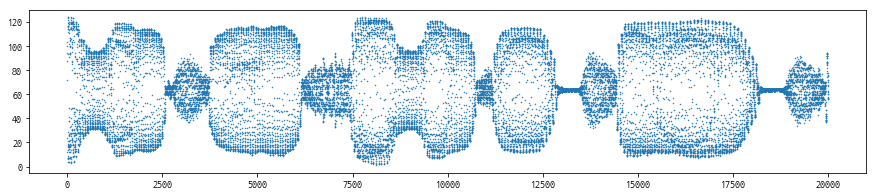

In [8]:
g = data_generation(data,fs,mu=128, seq_size=20000,ctx=ctx)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(list(x.asnumpy()),'.', ms=1)

## listen to signal

In [9]:
x = next(g)
y = x.asnumpy()
y = decode_mu_law(y, 128)
Audio(y,rate=fs)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

In [10]:
net = WaveNet(mu=128,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.collect_params().initialize(ctx=ctx)
#set optimizer
trainer = gluon.Trainer(net.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.01 })
g = data_generation(data,fs,mu=128, seq_size=20000,ctx=ctx)
batch_size = 64
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

  0%|          | 0/1000 [00:00<?, ?it/s]

====save best model====
epoch 0, loss 71740.71875


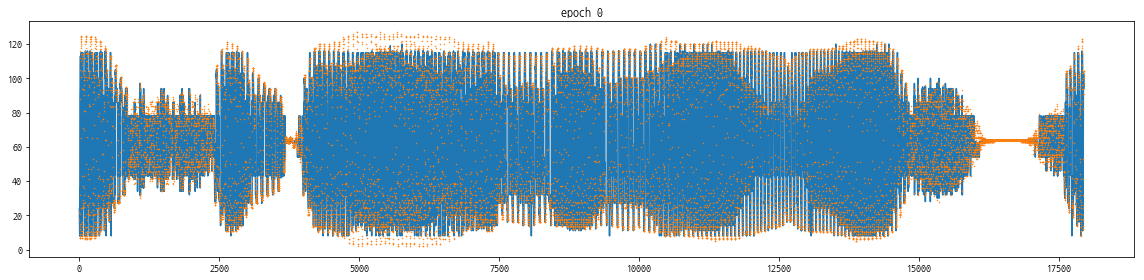

  0%|          | 2/1000 [01:00<8:19:58, 30.06s/it]

====save best model====


  0%|          | 3/1000 [01:29<8:15:03, 29.79s/it]

====save best model====


  0%|          | 4/1000 [01:58<8:12:41, 29.68s/it]

====save best model====


  0%|          | 5/1000 [02:28<8:11:16, 29.63s/it]

====save best model====


  1%|          | 6/1000 [02:57<8:09:42, 29.56s/it]

====save best model====


  1%|          | 7/1000 [03:26<8:08:23, 29.51s/it]

====save best model====


  1%|          | 8/1000 [03:55<8:07:22, 29.48s/it]

====save best model====


  1%|          | 9/1000 [04:25<8:06:28, 29.45s/it]

====save best model====


  1%|          | 10/1000 [04:54<8:05:40, 29.44s/it]

====save best model====


  1%|          | 11/1000 [05:23<8:04:54, 29.42s/it]

====save best model====
====save best model====


  1%|▏         | 13/1000 [06:22<8:03:53, 29.42s/it]

====save best model====


  2%|▏         | 15/1000 [07:20<8:02:29, 29.39s/it]

====save best model====


  2%|▏         | 16/1000 [07:50<8:01:55, 29.39s/it]

====save best model====


  2%|▏         | 17/1000 [08:19<8:01:20, 29.38s/it]

====save best model====


  2%|▏         | 18/1000 [08:48<8:00:45, 29.37s/it]

====save best model====


  2%|▏         | 19/1000 [09:18<8:00:25, 29.38s/it]

====save best model====


  2%|▏         | 21/1000 [10:17<7:59:30, 29.39s/it]

====save best model====


  2%|▏         | 23/1000 [11:15<7:58:16, 29.37s/it]

====save best model====


  2%|▎         | 25/1000 [12:14<7:57:18, 29.37s/it]

====save best model====


  3%|▎         | 28/1000 [13:42<7:55:38, 29.36s/it]

====save best model====


  3%|▎         | 30/1000 [14:40<7:54:32, 29.35s/it]

====save best model====


  3%|▎         | 33/1000 [16:08<7:53:00, 29.35s/it]

====save best model====


  4%|▍         | 38/1000 [18:34<7:50:18, 29.33s/it]

====save best model====
====save best model====


  5%|▍         | 47/1000 [22:58<7:45:42, 29.32s/it]

====save best model====
====save best model====


  7%|▋         | 67/1000 [32:43<7:35:36, 29.30s/it]

====save best model====


  7%|▋         | 69/1000 [33:41<7:34:39, 29.30s/it]

====save best model====


  7%|▋         | 73/1000 [35:38<7:32:38, 29.30s/it]

====save best model====


  7%|▋         | 74/1000 [36:07<7:32:09, 29.30s/it]

====save best model====


  8%|▊         | 84/1000 [41:00<7:27:13, 29.29s/it]

====save best model====


 10%|█         | 100/1000 [48:50<7:19:33, 29.30s/it]

epoch 100, loss 1881.97509765625


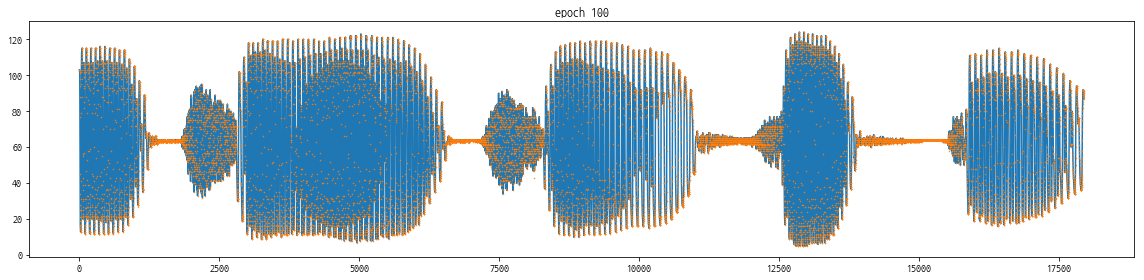

 10%|█         | 102/1000 [49:49<7:18:41, 29.31s/it]

====save best model====


 10%|█         | 104/1000 [50:48<7:17:45, 29.31s/it]

====save best model====


 10%|█         | 105/1000 [51:18<7:17:17, 29.32s/it]

====save best model====


 15%|█▌        | 150/1000 [1:13:20<6:55:38, 29.34s/it]

====save best model====


 19%|█▉        | 191/1000 [1:33:25<6:35:44, 29.35s/it]

====save best model====


 20%|██        | 200/1000 [1:37:50<6:31:23, 29.35s/it]

epoch 200, loss 801.8182983398438


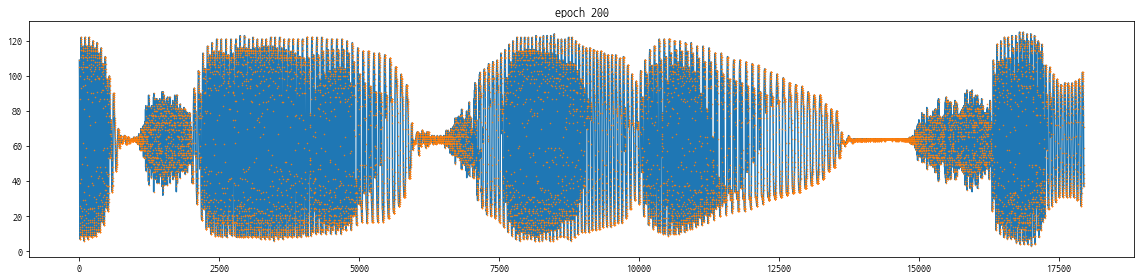

 24%|██▍       | 244/1000 [1:59:24<6:09:59, 29.36s/it]

====save best model====


 25%|██▌       | 253/1000 [2:03:49<6:05:34, 29.36s/it]

====save best model====


 26%|██▋       | 264/1000 [2:09:12<6:00:14, 29.37s/it]

====save best model====


 26%|██▋       | 265/1000 [2:09:42<5:59:45, 29.37s/it]

====save best model====


 27%|██▋       | 266/1000 [2:10:12<5:59:16, 29.37s/it]

====save best model====


 30%|███       | 300/1000 [2:26:52<5:42:41, 29.37s/it]

epoch 300, loss 41.383602142333984


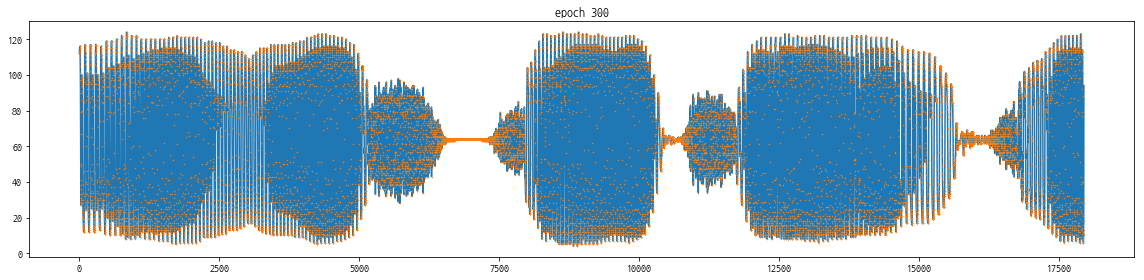

 33%|███▎      | 326/1000 [2:39:39<5:30:05, 29.39s/it]

====save best model====


 33%|███▎      | 329/1000 [2:41:08<5:28:38, 29.39s/it]

====save best model====


 38%|███▊      | 385/1000 [3:08:33<5:01:12, 29.39s/it]

====save best model====


 40%|████      | 400/1000 [3:15:54<4:53:51, 29.39s/it]

epoch 400, loss 1632.37646484375


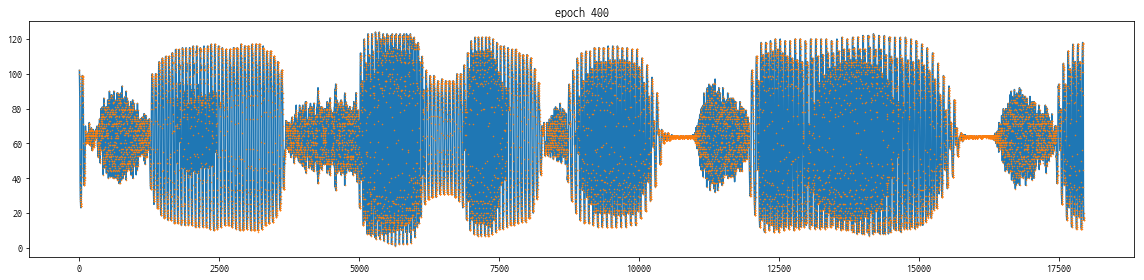

 41%|████      | 410/1000 [3:20:48<4:48:58, 29.39s/it]

====save best model====


 44%|████▍     | 442/1000 [3:36:28<4:33:16, 29.39s/it]

====save best model====


 44%|████▍     | 444/1000 [3:37:26<4:32:17, 29.38s/it]

====save best model====


 45%|████▍     | 447/1000 [3:38:54<4:30:49, 29.38s/it]

====save best model====


 45%|████▍     | 449/1000 [3:39:53<4:29:50, 29.38s/it]

====save best model====


 50%|█████     | 500/1000 [4:04:46<4:04:46, 29.37s/it]

epoch 500, loss 24.531505584716797


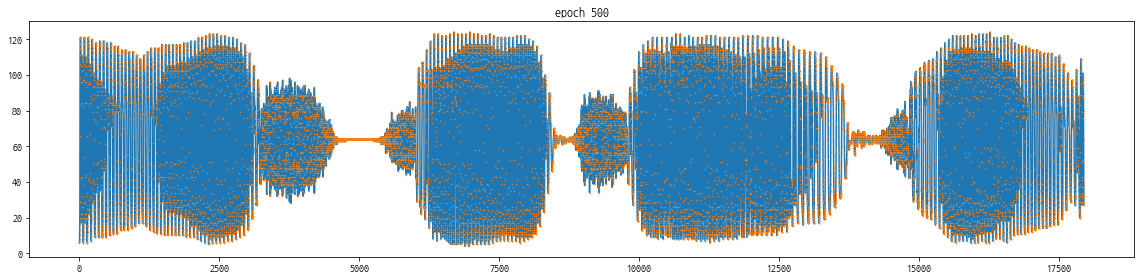

 60%|██████    | 600/1000 [4:53:33<3:15:42, 29.36s/it]

epoch 600, loss 128.34893798828125


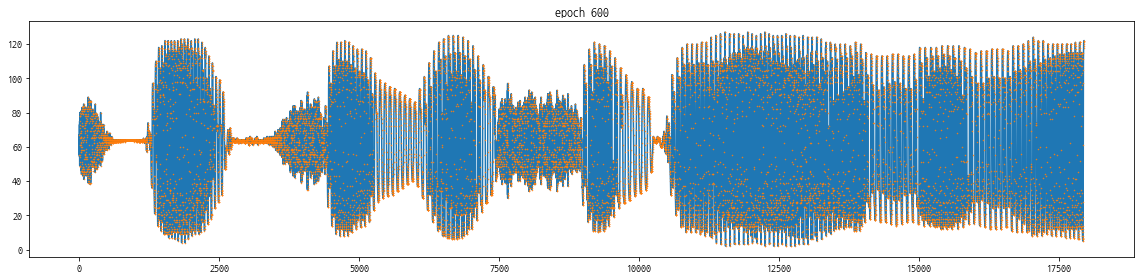

 70%|███████   | 700/1000 [5:42:20<2:26:43, 29.34s/it]

epoch 700, loss 143.25576782226562


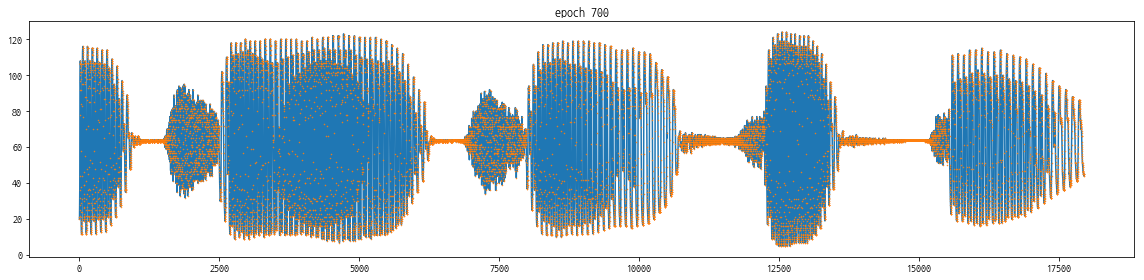

 80%|████████  | 800/1000 [6:31:07<1:37:46, 29.33s/it]

epoch 800, loss 1548.9625244140625


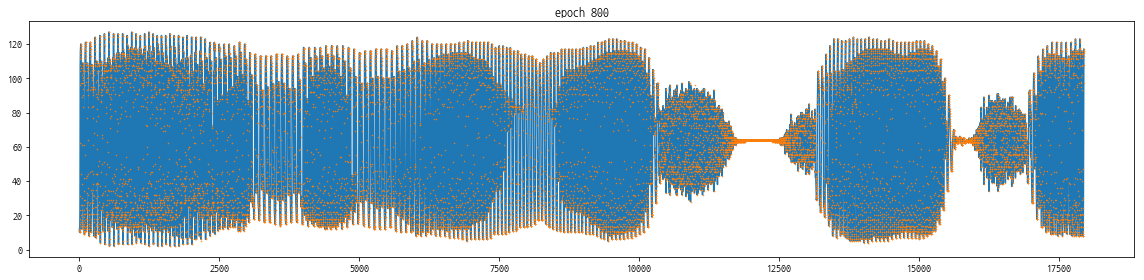

 90%|█████████ | 900/1000 [7:19:55<48:52, 29.33s/it]  

epoch 900, loss 1332.426513671875


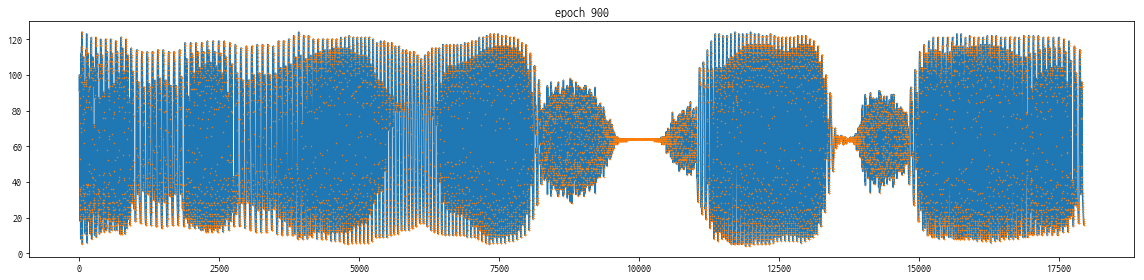

100%|██████████| 1000/1000 [8:08:42<00:00, 29.32s/it]


In [11]:
loss_save = []
loss_for_epoch =[]
max_epoch = 1000
best_loss = sys.maxsize
for epoch in trange(max_epoch):
    loss = 0.0
    for _ in range(batch_size):
        batch = next(g)
        x = batch[:-1]
        with autograd.record():
            logits = net(x)
            sz = logits.shape[0]
            loss = loss + loss_fn(logits, batch[-sz:])
            #loss = loss/batch_size
        loss.backward()
        trainer.step(1,ignore_stale_grad=True)
    loss_save.append(nd.sum(loss).asscalar()/batch_size)

    #save the best model
    current_loss = nd.sum(loss).asscalar()/batch_size
    loss_for_epoch.append(current_loss)
    if best_loss > current_loss:
        
        print("====save best model====")
        filename = os.getcwd() + '/models/best_perf_epoch_'+str(epoch)+"_loss_"+str(current_loss)
        net.save_params(filename)
        best_loss = current_loss
    
    # monitor progress
    if epoch%100==0:
        print('epoch {}, loss {}'.format(epoch, nd.sum(loss).asscalar()/batch_size))
        batch = next(g)
        logits = net(batch[:-1])
        #_, i = logits.max(dim=1)
        i = logits.argmax(1).asnumpy()
        plt.figure(figsize=[16,4])
        plt.plot(list(i))
        plt.plot(list(batch.asnumpy())[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

In [13]:
def displly_plot(epoches, loss):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 12})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(15,10))
    plt.xlabel("Epoch")
    plt.ylabel("loss")

    plt.plot(np.arange(epoches)+1,  np.array(loss),label="loss")
    plt.legend(bbox_to_anchor=(1, 1), loc=2,)
    plt.show()

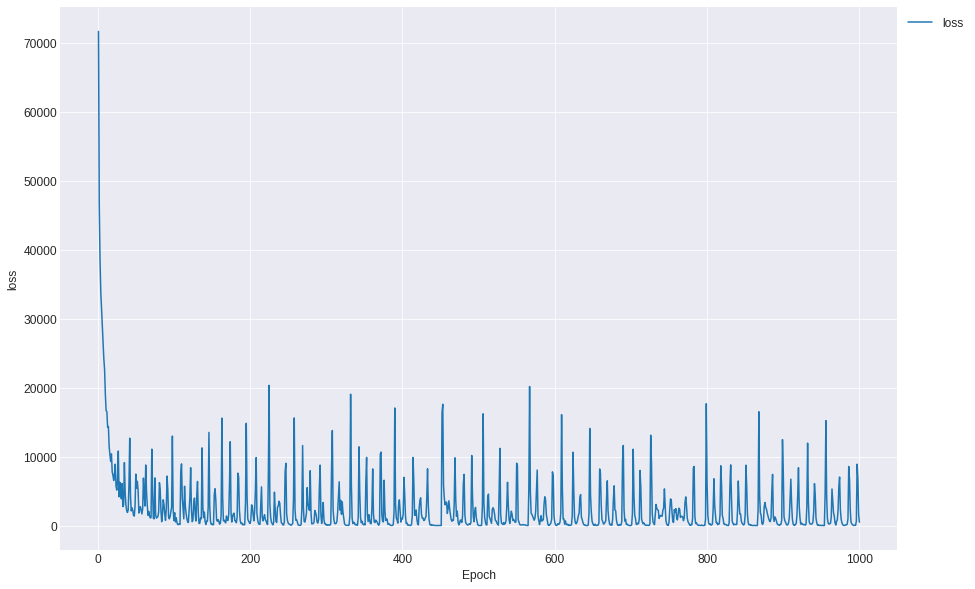

In [14]:
displly_plot(1000,loss_save)

In [126]:
##load best network
net.load_params(os.getcwd()+'/models/best_perf_epoch_963_loss_9.889945983886719')

In [127]:
def generate_slow(x,models,dilation_depth,n_repeat,ctx, n=100):
    dilations = [2**i for i in range(dilation_depth)] * n_repeat 
    res = list(x.asnumpy())
    for _ in tqdm(range(n)):
        x = nd.array(res[-sum(dilations)-1:],ctx=ctx)
        y = models(x)
        res.append(y.argmax(1).asnumpy()[-1])
    return res

In [128]:
dilation_depth = 10
n_repeat = 2
dilations = [2**i for i in range(dilation_depth)] * n_repeat 

In [138]:
def data_generation_sample(data, framerate, seq_size, mu, ctx):
    #t = np.linspace(0,5,framerate*5)
    #data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    div = max(data.max(),abs(data.min()))
    data = data/div
    start = 10
    ys = data[start:start+seq_size]
    ys = encode_mu_law(ys,mu)
    return nd.array(ys[:seq_size],ctx=ctx)

In [139]:
sampe_data = data_generation_sample(data,fs,mu=128, seq_size=3000,ctx=ctx)

In [140]:
sampe_data


[64. 64. 64. ... 48. 76. 55.]
<NDArray 3000 @gpu(1)>

In [141]:
sampe_data.max()


[126.]
<NDArray 1 @gpu(1)>

In [142]:
gen_rst = generate_slow(sampe_data,net,dilation_depth=10,n_repeat=2,n=20000,ctx=ctx)



  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 6/20000 [00:00<06:18, 52.85it/s]

  0%|          | 13/20000 [00:00<05:33, 59.95it/s]

  0%|          | 20/20000 [00:00<05:21, 62.05it/s]

  0%|          | 27/20000 [00:00<05:16, 63.11it/s]

  0%|          | 34/20000 [00:00<05:14, 63.55it/s]

  0%|          | 41/20000 [00:00<05:11, 64.05it/s]

  0%|          | 48/20000 [00:00<05:08, 64.76it/s]

  0%|          | 56/20000 [00:00<05:03, 65.70it/s]

  0%|          | 64/20000 [00:00<05:00, 66.25it/s]

  0%|          | 72/20000 [00:01<04:58, 66.72it/s]

  0%|          | 79/20000 [00:01<04:57, 66.93it/s]

  0%|          | 87/20000 [00:01<04:55, 67.28it/s]

  0%|          | 95/20000 [00:01<04:54, 67.57it/s]

  1%|          | 102/20000 [00:01<04:53, 67.69it/s]

  1%|          | 110/20000 [00:01<04:52, 67.91it/s]

  1%|          | 118/20000 [00:01<04:51, 68.11it/s]

  1%|          | 126/20000 [00:01<04:51, 68.27it/s]

  1%|          | 134/20000 [00:01<04:50, 68.40it/s]

  1%|          

 10%|█         | 2046/20000 [00:29<04:20, 68.90it/s]

 10%|█         | 2053/20000 [00:29<04:20, 68.90it/s]

 10%|█         | 2060/20000 [00:29<04:20, 68.87it/s]

 10%|█         | 2067/20000 [00:30<04:20, 68.84it/s]

 10%|█         | 2074/20000 [00:30<04:20, 68.81it/s]

 10%|█         | 2081/20000 [00:30<04:20, 68.78it/s]

 10%|█         | 2088/20000 [00:30<04:20, 68.76it/s]

 10%|█         | 2095/20000 [00:30<04:20, 68.73it/s]

 11%|█         | 2102/20000 [00:30<04:20, 68.70it/s]

 11%|█         | 2109/20000 [00:30<04:20, 68.67it/s]

 11%|█         | 2116/20000 [00:30<04:20, 68.64it/s]

 11%|█         | 2123/20000 [00:30<04:20, 68.62it/s]

 11%|█         | 2130/20000 [00:31<04:20, 68.59it/s]

 11%|█         | 2137/20000 [00:31<04:20, 68.57it/s]

 11%|█         | 2144/20000 [00:31<04:20, 68.54it/s]

 11%|█         | 2151/20000 [00:31<04:20, 68.53it/s]

 11%|█         | 2158/20000 [00:31<04:20, 68.53it/s]

 11%|█         | 2165/20000 [00:31<04:20, 68.52it/s]

 11%|█         | 2172/20000 

 20%|██        | 4037/20000 [00:59<03:54, 68.05it/s]

 20%|██        | 4045/20000 [00:59<03:54, 68.06it/s]

 20%|██        | 4053/20000 [00:59<03:54, 68.07it/s]

 20%|██        | 4061/20000 [00:59<03:54, 68.07it/s]

 20%|██        | 4069/20000 [00:59<03:54, 68.08it/s]

 20%|██        | 4077/20000 [00:59<03:53, 68.08it/s]

 20%|██        | 4085/20000 [00:59<03:53, 68.09it/s]

 20%|██        | 4093/20000 [01:00<03:53, 68.09it/s]

 21%|██        | 4101/20000 [01:00<03:53, 68.10it/s]

 21%|██        | 4109/20000 [01:00<03:53, 68.11it/s]

 21%|██        | 4117/20000 [01:00<03:53, 68.11it/s]

 21%|██        | 4125/20000 [01:00<03:53, 68.12it/s]

 21%|██        | 4133/20000 [01:00<03:52, 68.12it/s]

 21%|██        | 4141/20000 [01:00<03:52, 68.13it/s]

 21%|██        | 4149/20000 [01:00<03:52, 68.13it/s]

 21%|██        | 4157/20000 [01:01<03:52, 68.14it/s]

 21%|██        | 4165/20000 [01:01<03:52, 68.14it/s]

 21%|██        | 4173/20000 [01:01<03:52, 68.15it/s]

 21%|██        | 4181/20000 

 31%|███       | 6132/20000 [01:29<03:22, 68.53it/s]

 31%|███       | 6139/20000 [01:29<03:22, 68.53it/s]

 31%|███       | 6146/20000 [01:29<03:22, 68.53it/s]

 31%|███       | 6153/20000 [01:29<03:22, 68.52it/s]

 31%|███       | 6160/20000 [01:29<03:21, 68.52it/s]

 31%|███       | 6167/20000 [01:30<03:21, 68.51it/s]

 31%|███       | 6174/20000 [01:30<03:21, 68.51it/s]

 31%|███       | 6181/20000 [01:30<03:21, 68.51it/s]

 31%|███       | 6188/20000 [01:30<03:21, 68.50it/s]

 31%|███       | 6195/20000 [01:30<03:21, 68.50it/s]

 31%|███       | 6202/20000 [01:30<03:21, 68.49it/s]

 31%|███       | 6209/20000 [01:30<03:21, 68.48it/s]

 31%|███       | 6216/20000 [01:30<03:21, 68.48it/s]

 31%|███       | 6223/20000 [01:30<03:21, 68.47it/s]

 31%|███       | 6230/20000 [01:30<03:21, 68.47it/s]

 31%|███       | 6237/20000 [01:31<03:20, 68.47it/s]

 31%|███       | 6244/20000 [01:31<03:20, 68.47it/s]

 31%|███▏      | 6251/20000 [01:31<03:20, 68.46it/s]

 31%|███▏      | 6258/20000 

 40%|████      | 8036/20000 [01:58<02:56, 67.89it/s]

 40%|████      | 8043/20000 [01:58<02:56, 67.89it/s]

 40%|████      | 8050/20000 [01:58<02:56, 67.89it/s]

 40%|████      | 8057/20000 [01:58<02:55, 67.89it/s]

 40%|████      | 8064/20000 [01:58<02:55, 67.89it/s]

 40%|████      | 8071/20000 [01:58<02:55, 67.89it/s]

 40%|████      | 8078/20000 [01:58<02:55, 67.89it/s]

 40%|████      | 8085/20000 [01:59<02:55, 67.89it/s]

 40%|████      | 8092/20000 [01:59<02:55, 67.89it/s]

 40%|████      | 8099/20000 [01:59<02:55, 67.89it/s]

 41%|████      | 8106/20000 [01:59<02:55, 67.89it/s]

 41%|████      | 8113/20000 [01:59<02:55, 67.89it/s]

 41%|████      | 8120/20000 [01:59<02:54, 67.89it/s]

 41%|████      | 8127/20000 [01:59<02:54, 67.89it/s]

 41%|████      | 8134/20000 [01:59<02:54, 67.89it/s]

 41%|████      | 8141/20000 [01:59<02:54, 67.89it/s]

 41%|████      | 8148/20000 [02:00<02:54, 67.89it/s]

 41%|████      | 8155/20000 [02:00<02:54, 67.89it/s]

 41%|████      | 8162/20000 

 50%|█████     | 10006/20000 [02:27<02:27, 67.81it/s]

 50%|█████     | 10013/20000 [02:27<02:27, 67.81it/s]

 50%|█████     | 10020/20000 [02:27<02:27, 67.81it/s]

 50%|█████     | 10027/20000 [02:27<02:27, 67.81it/s]

 50%|█████     | 10034/20000 [02:27<02:26, 67.81it/s]

 50%|█████     | 10042/20000 [02:28<02:26, 67.81it/s]

 50%|█████     | 10050/20000 [02:28<02:26, 67.81it/s]

 50%|█████     | 10058/20000 [02:28<02:26, 67.81it/s]

 50%|█████     | 10065/20000 [02:28<02:26, 67.81it/s]

 50%|█████     | 10072/20000 [02:28<02:26, 67.81it/s]

 50%|█████     | 10079/20000 [02:28<02:26, 67.82it/s]

 50%|█████     | 10087/20000 [02:28<02:26, 67.82it/s]

 50%|█████     | 10094/20000 [02:28<02:26, 67.82it/s]

 51%|█████     | 10101/20000 [02:28<02:25, 67.82it/s]

 51%|█████     | 10108/20000 [02:29<02:25, 67.82it/s]

 51%|█████     | 10115/20000 [02:29<02:25, 67.82it/s]

 51%|█████     | 10122/20000 [02:29<02:25, 67.82it/s]

 51%|█████     | 10129/20000 [02:29<02:25, 67.82it/s]

 51%|█████

 60%|█████▉    | 11911/20000 [02:56<01:59, 67.41it/s]

 60%|█████▉    | 11918/20000 [02:56<01:59, 67.42it/s]

 60%|█████▉    | 11926/20000 [02:56<01:59, 67.42it/s]

 60%|█████▉    | 11933/20000 [02:56<01:59, 67.42it/s]

 60%|█████▉    | 11941/20000 [02:57<01:59, 67.42it/s]

 60%|█████▉    | 11948/20000 [02:57<01:59, 67.42it/s]

 60%|█████▉    | 11956/20000 [02:57<01:59, 67.42it/s]

 60%|█████▉    | 11963/20000 [02:57<01:59, 67.42it/s]

 60%|█████▉    | 11970/20000 [02:57<01:59, 67.42it/s]

 60%|█████▉    | 11977/20000 [02:57<01:58, 67.43it/s]

 60%|█████▉    | 11984/20000 [02:57<01:58, 67.43it/s]

 60%|█████▉    | 11991/20000 [02:57<01:58, 67.43it/s]

 60%|█████▉    | 11998/20000 [02:57<01:58, 67.43it/s]

 60%|██████    | 12005/20000 [02:58<01:58, 67.43it/s]

 60%|██████    | 12012/20000 [02:58<01:58, 67.43it/s]

 60%|██████    | 12019/20000 [02:58<01:58, 67.43it/s]

 60%|██████    | 12026/20000 [02:58<01:58, 67.43it/s]

 60%|██████    | 12033/20000 [02:58<01:58, 67.43it/s]

 60%|█████

 69%|██████▉   | 13790/20000 [03:25<01:32, 67.19it/s]

 69%|██████▉   | 13797/20000 [03:25<01:32, 67.19it/s]

 69%|██████▉   | 13804/20000 [03:25<01:32, 67.19it/s]

 69%|██████▉   | 13811/20000 [03:25<01:32, 67.19it/s]

 69%|██████▉   | 13818/20000 [03:25<01:32, 67.19it/s]

 69%|██████▉   | 13825/20000 [03:25<01:31, 67.19it/s]

 69%|██████▉   | 13832/20000 [03:25<01:31, 67.19it/s]

 69%|██████▉   | 13839/20000 [03:25<01:31, 67.19it/s]

 69%|██████▉   | 13846/20000 [03:26<01:31, 67.19it/s]

 69%|██████▉   | 13853/20000 [03:26<01:31, 67.19it/s]

 69%|██████▉   | 13860/20000 [03:26<01:31, 67.19it/s]

 69%|██████▉   | 13867/20000 [03:26<01:31, 67.18it/s]

 69%|██████▉   | 13874/20000 [03:26<01:31, 67.18it/s]

 69%|██████▉   | 13881/20000 [03:26<01:31, 67.18it/s]

 69%|██████▉   | 13888/20000 [03:26<01:30, 67.18it/s]

 69%|██████▉   | 13895/20000 [03:26<01:30, 67.18it/s]

 70%|██████▉   | 13902/20000 [03:26<01:30, 67.17it/s]

 70%|██████▉   | 13909/20000 [03:27<01:30, 67.17it/s]

 70%|█████

 78%|███████▊  | 15694/20000 [03:53<01:04, 67.09it/s]

 79%|███████▊  | 15701/20000 [03:54<01:04, 67.09it/s]

 79%|███████▊  | 15708/20000 [03:54<01:03, 67.09it/s]

 79%|███████▊  | 15715/20000 [03:54<01:03, 67.09it/s]

 79%|███████▊  | 15722/20000 [03:54<01:03, 67.09it/s]

 79%|███████▊  | 15729/20000 [03:54<01:03, 67.09it/s]

 79%|███████▊  | 15736/20000 [03:54<01:03, 67.09it/s]

 79%|███████▊  | 15743/20000 [03:54<01:03, 67.09it/s]

 79%|███████▉  | 15750/20000 [03:54<01:03, 67.08it/s]

 79%|███████▉  | 15757/20000 [03:54<01:03, 67.08it/s]

 79%|███████▉  | 15764/20000 [03:55<01:03, 67.08it/s]

 79%|███████▉  | 15771/20000 [03:55<01:03, 67.08it/s]

 79%|███████▉  | 15778/20000 [03:55<01:02, 67.08it/s]

 79%|███████▉  | 15785/20000 [03:55<01:02, 67.08it/s]

 79%|███████▉  | 15792/20000 [03:55<01:02, 67.07it/s]

 79%|███████▉  | 15799/20000 [03:55<01:02, 67.07it/s]

 79%|███████▉  | 15806/20000 [03:55<01:02, 67.07it/s]

 79%|███████▉  | 15813/20000 [03:55<01:02, 67.07it/s]

 79%|█████

 88%|████████▊ | 17571/20000 [04:21<00:36, 67.07it/s]

 88%|████████▊ | 17578/20000 [04:22<00:36, 67.07it/s]

 88%|████████▊ | 17585/20000 [04:22<00:36, 67.07it/s]

 88%|████████▊ | 17592/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17599/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17606/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17613/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17620/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17627/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17634/20000 [04:22<00:35, 67.07it/s]

 88%|████████▊ | 17641/20000 [04:23<00:35, 67.07it/s]

 88%|████████▊ | 17648/20000 [04:23<00:35, 67.07it/s]

 88%|████████▊ | 17655/20000 [04:23<00:34, 67.07it/s]

 88%|████████▊ | 17662/20000 [04:23<00:34, 67.07it/s]

 88%|████████▊ | 17669/20000 [04:23<00:34, 67.07it/s]

 88%|████████▊ | 17676/20000 [04:23<00:34, 67.07it/s]

 88%|████████▊ | 17683/20000 [04:23<00:34, 67.07it/s]

 88%|████████▊ | 17690/20000 [04:23<00:34, 67.07it/s]

 88%|█████

 97%|█████████▋| 19456/20000 [04:50<00:08, 67.08it/s]

 97%|█████████▋| 19463/20000 [04:50<00:08, 67.08it/s]

 97%|█████████▋| 19470/20000 [04:50<00:07, 67.08it/s]

 97%|█████████▋| 19477/20000 [04:50<00:07, 67.08it/s]

 97%|█████████▋| 19484/20000 [04:50<00:07, 67.08it/s]

 97%|█████████▋| 19491/20000 [04:50<00:07, 67.08it/s]

 97%|█████████▋| 19498/20000 [04:50<00:07, 67.08it/s]

 98%|█████████▊| 19505/20000 [04:50<00:07, 67.08it/s]

 98%|█████████▊| 19512/20000 [04:50<00:07, 67.08it/s]

 98%|█████████▊| 19519/20000 [04:50<00:07, 67.08it/s]

 98%|█████████▊| 19526/20000 [04:51<00:07, 67.08it/s]

 98%|█████████▊| 19533/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19540/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19547/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19554/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19561/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19568/20000 [04:51<00:06, 67.08it/s]

 98%|█████████▊| 19575/20000 [04:51<00:06, 67.08it/s]

 98%|█████

In [143]:
gen_wav= np.array(gen_rst)
gen_wav = decode_mu_law(gen_wav, 128)
Audio(gen_wav,rate=fs)

In [144]:
a = np.array(gen_rst)

In [147]:
a[3000:].min()

9.0